In [1]:
! which python

/Users/no_lineal/opt/anaconda3/envs/grid38/bin/python


In [2]:
import numpy as np
import torch

from polygon import get_polygon

from place_cells import PlaceCells
from trajectory_generator import TrajectoryGenerator

from model import RNN

from visualize import compute_ratemaps, plot_ratemaps

from scores import GridScorer

from tqdm import tqdm

import json

import os

# viz
from matplotlib import pyplot as plt

In [3]:
"""

    where am i?

"""

PATH = os.getcwd() + '/'
experiment_path = PATH + 'experiment/'
precomputed_path = PATH + 'precomputed/'

print(f'PATH: {PATH}')
print(f'experiment path: {experiment_path}')
print(f'models path: {precomputed_path}')

PATH: /Users/no_lineal/Documents/GitHub/grid-pattern-formation-boundaries/
experiment path: /Users/no_lineal/Documents/GitHub/grid-pattern-formation-boundaries/experiment/
models path: /Users/no_lineal/Documents/GitHub/grid-pattern-formation-boundaries/precomputed/


In [4]:
"""

    device

"""

device = 'cuda' if torch.cuda.is_available() else 'cpu'

print(f'device: {device}')

device: cpu


In [5]:
""" 

    options and hyperparameters

""" 

class Options():
    pass

def generate_options( parameters ):

    load_path = PATH + '/pre_computed/'
    save_path = PATH + '/output/'

    options = Options()

    global_parameters = parameters.keys()

    for p in global_parameters:
        
        try:
            for k, v in parameters[p].items():

                options.__dict__[k] = v

        except:

            options.__dict__[p] = parameters[p]

    options.load_path = load_path
    options.save_path = save_path
    options.device = device

    return options

input_file = PATH + 'experiments/hall_square.json'

# load JSON file
with open( input_file ) as f:
    parameters = json.load( f )

options = generate_options( parameters )

print( options )

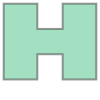

In [6]:
""" 

    polygon

"""

polygon = get_polygon( options.shape )

polygon

In [7]:
""" 

    place cells

"""

place_cells = PlaceCells( options, polygon)

In [8]:
"""  

    trajectory generator

"""

trajectory_generator = TrajectoryGenerator( options, place_cells, polygon )

place cells:        torch.Size([1024, 2])
input velocity:     torch.Size([20, 400, 2])
input activation:   torch.Size([400, 1024])
input positions:    torch.Size([20, 400, 2])
place cells output: torch.Size([20, 400, 1024])


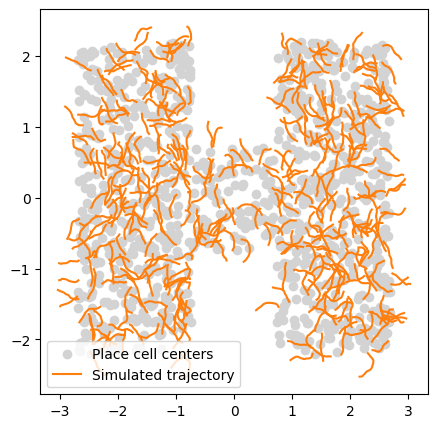

In [9]:
"""

    viz grid and trajectories

"""

us = place_cells.us.cpu() # place cells matrix

pc_inputs, position, pc_outputs = trajectory_generator.get_test_batch()
position = position.cpu()

print(f'place cells:        {us.shape}')
print(f'input velocity:     {pc_inputs[0].shape}')
print(f'input activation:   {pc_inputs[1].shape}')
print(f'input positions:    {position.shape}')
print(f'place cells output: {pc_outputs.shape}')

plt.figure(figsize=(5,5))
plt.scatter(us[:,0], us[:,1], c='lightgrey', label='Place cell centers')

for i in range( position.shape[1] ):
    plt.plot( position[:,i,0], position[:,i,1], label='Simulated trajectory', c='C1')
    if i==0:
        plt.legend();

place cell outputs: torch.Size([8000, 1024])
place cell grid: (8000, 32, 32)


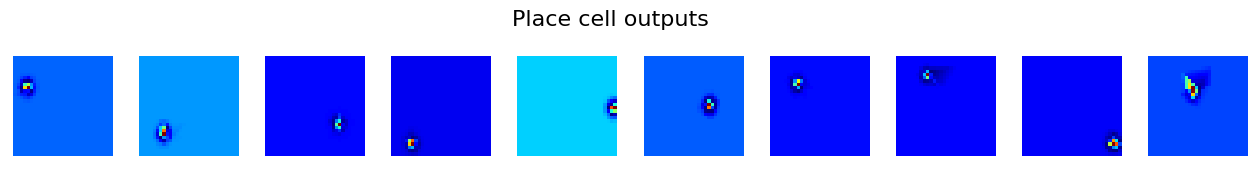

In [10]:
"""

    place cell output

"""

pc_outputs = pc_outputs.reshape( -1, options.Np ).detach().cpu()
pc = place_cells.grid_pc( pc_outputs )

print(f'place cell outputs: {pc_outputs.shape}')
print(f'place cell grid: {pc.shape}')

plt.figure(figsize=(16,2))

for i in range(10):
    
    plt.subplot(1, 10, i+1)
    plt.imshow( pc[i], cmap='jet' )
    plt.axis('off')
        
plt.suptitle('Place cell outputs', fontsize=16)
plt.show()

C mean: (30, 30)
C tilde: (30, 30)


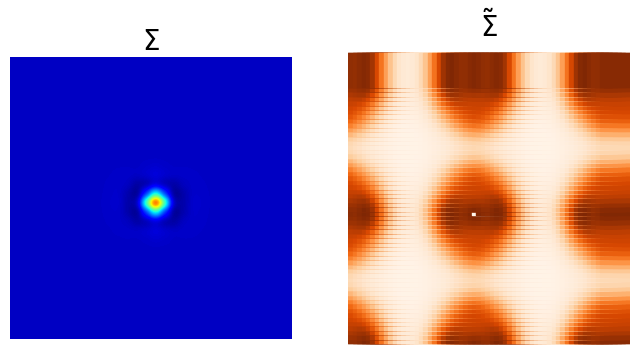

In [11]:
"""

    covariance matrix

"""

Cmean = place_cells.compute_covariance()

# Fourier transform
Ctilde = np.fft.fft2(Cmean)
Ctilde[0,0] = 0

print(f'C mean: {Cmean.shape}')
print(f'C tilde: {Ctilde.shape}')

plt.figure(figsize=(8,4))

plt.subplot(121)
plt.imshow(Cmean, cmap='jet', interpolation='gaussian')
plt.axis('off')
plt.title(r'$\Sigma$', fontsize=20)

plt.subplot(122)

width = 30
idxs = np.arange( -width + 1 , width )

x2, y2 = np.meshgrid(np.arange(2*width-1), np.arange(2*width-1))

plt.scatter(
    x2, 
    y2,
    c=np.abs(Ctilde)[idxs][:,idxs], 
    s=600, 
    cmap='Oranges', 
    marker='s'
)

plt.axis('equal')
plt.axis('off')
plt.title(r'$\tilde \Sigma$', fontsize=20)
plt.axis('off');

In [12]:
""" 

    load model

"""

model = RNN( options, place_cells )

print('\n')
print('model: ')
print( model )
print('\n')

checkpoint_file = precomputed_path + 'most_recent_model_hall.pth'

print(f'checkpoint file: {checkpoint_file}')

checkpoint = torch.load( checkpoint_file, map_location=torch.device('cpu') )
model.load_state_dict( checkpoint  )



model: 
RNN(
  (encoder): Linear(in_features=1024, out_features=8192, bias=False)
  (RNN): RNN(2, 8192, bias=False)
  (decoder): Linear(in_features=8192, out_features=1024, bias=False)
  (softmax): Softmax(dim=-1)
)


checkpoint file: /Users/no_lineal/Documents/GitHub/grid-pattern-formation-boundaries/precomputed/most_recent_model_hall.pth


<All keys matched successfully>

In [13]:
"""

    validate performance

"""

pc_inputs, position, pc_outputs = trajectory_generator.get_test_batch()

position = position.cpu()

pc_predict = model.predict( pc_inputs )

print(f'input velocity:     {pc_inputs[0].shape}')
print(f'input activation:   {pc_inputs[1].shape}')
print(f'place cell predict: {pc_predict.shape}')

pred_pos = place_cells.get_nearest_cell_pos( pc_predict ).cpu()

print(f'predicted positions: {pred_pos.shape}')

us = place_cells.us.cpu()
print(f'place cells: {us.shape}')


input velocity:     torch.Size([20, 400, 2])
input activation:   torch.Size([400, 1024])
place cell predict: torch.Size([20, 400, 1024])
predicted positions: torch.Size([20, 400, 2])
place cells: torch.Size([1024, 2])


([], [])

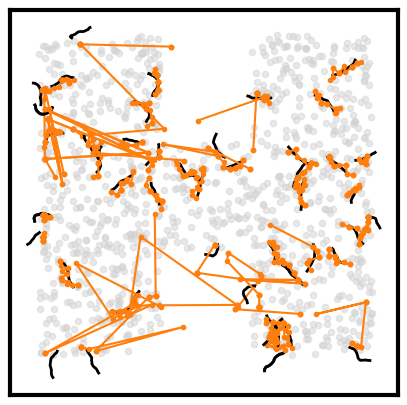

In [14]:
"""

    viz predicted positions

"""

sample = np.random.choice( list( range(400) ), 50 )

fig = plt.figure(figsize=(5,5))

ax = fig.add_subplot(111)

#for i in range(400):
for i in sample:
    plt.plot( position[:,i,0], position[:,i,1], c='black', label='True position', linewidth=2 )
    plt.plot( pred_pos[:,i,0], pred_pos[:,i,1], '.-',
             c='C1', label='Decoded position')
    if i==0:
        plt.legend()

plt.scatter( us[:,0], us[:,1], s=20, alpha=0.5, c='lightgrey' )

for axis in ['top','bottom','left','right']:
    ax.spines[axis].set_linewidth(3)
    
plt.xticks([])
plt.yticks([])

place cells outputs: torch.Size([8000, 1024])
place cells outputs grid: (8000, 32, 32)
place cells predict grid: (8000, 32, 32)


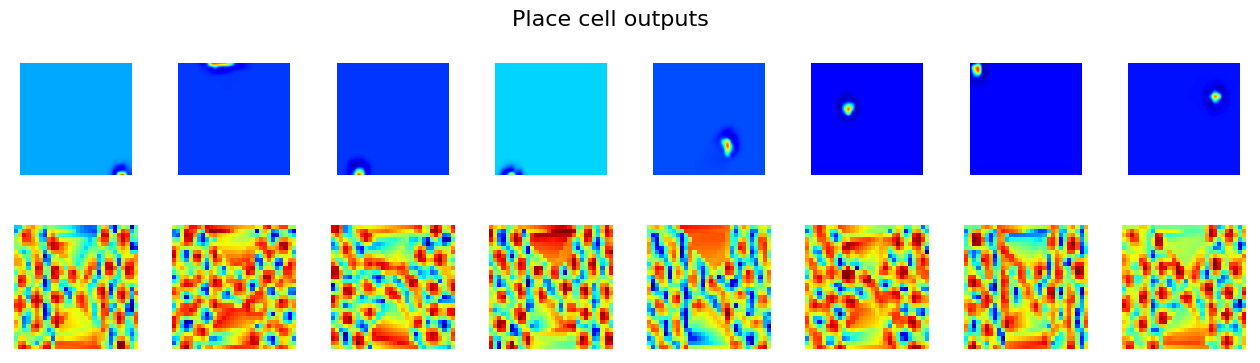

In [15]:
"""

    viz predicted place cell outputs

"""

pc_outputs_sm = model.softmax( pc_outputs ).reshape( -1, options.Np ).cpu()

pc_outputs_grid = place_cells.grid_pc( pc_outputs )
pc_predict_grid = place_cells.grid_pc( pc_predict.detach() )

print(f'place cells outputs: {pc_outputs_sm.shape}')
print(f'place cells outputs grid: {pc_outputs_grid.shape}')
print(f'place cells predict grid: {pc_predict_grid.shape}')

plt.figure(figsize=(16,4))
    
for i in range(8):
    
    plt.subplot(2,8,i+1)
    plt.imshow(pc_outputs_grid[2*i], cmap='jet', interpolation='gaussian')
    
    if i==0:
        plt.ylabel('True')
        
    plt.axis('off')
    
for i in range(8):
    
    plt.subplot(2, 8, i+9)
    plt.imshow(pc_predict_grid[2*i], cmap='jet')
    
    if i==0:
        plt.ylabel('Predicted')
        
    plt.axis('off')
    
plt.suptitle('Place cell outputs', fontsize=16)
plt.show()

100%|██████████| 20/20 [00:00<00:00, 1980.17it/s]


(-0.5, 859.5, 859.5, -0.5)

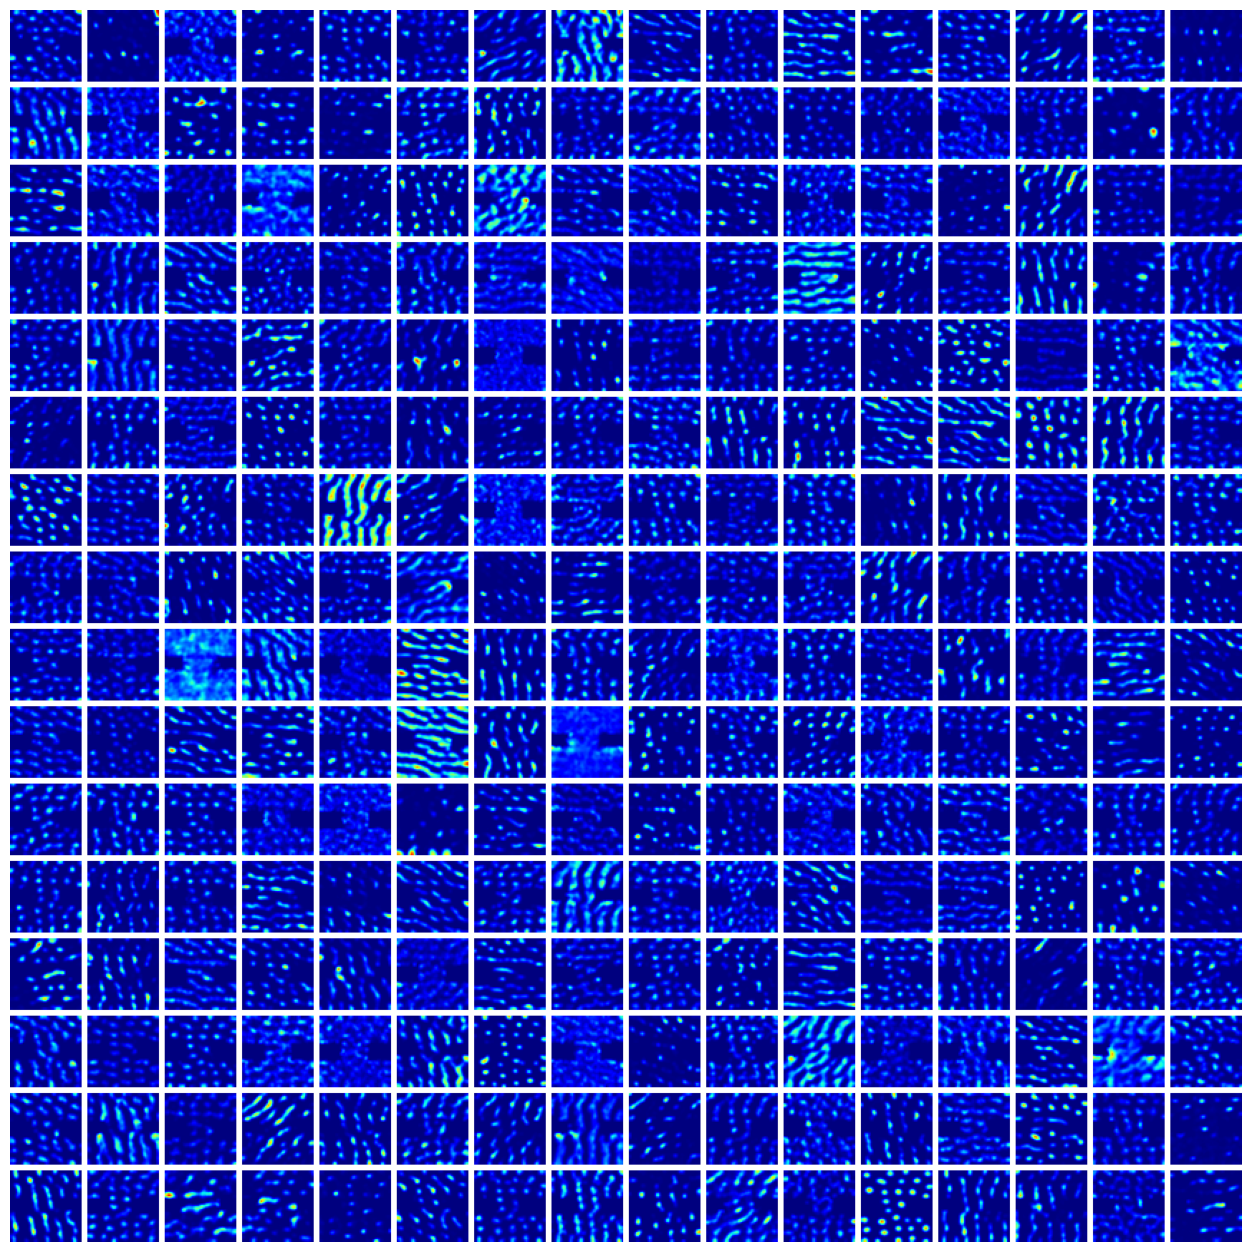

In [16]:
"""

    ratemaps

"""

n_avg = 25
Ng = options.Ng

res = 50
activations, rate_map, g, pos = compute_ratemaps(
    model=model, 
    trajectory_generator=trajectory_generator, 
    polygon=polygon,
    options=options, 
    res=res, 
    n_avg=n_avg, 
    Ng=Ng
)

# Compute a set of lo-res maps to use for evalutaing grid score
lo_res = 20
_, rate_map_lores, _, _ = compute_ratemaps(
    model=model,
    trajectory_generator=trajectory_generator, 
    polygon=polygon,
    options=options, 
    res=lo_res,
    n_avg=n_avg, 
    Ng=Ng
)

n_plot = 256
plt.figure(figsize=(16,4*n_plot//8**2))
rm_fig = plot_ratemaps(activations, n_plot, smooth=True)
plt.imshow(rm_fig)
plt.axis('off')

In [17]:
"""

    grid scores

"""

starts = [0.2] * 10
ends = np.linspace(0.4, 1.0, num=10)

min_x, min_y, max_x, max_y = polygon.bounds

width = max_x - min_x
height = max_y - min_y

box_width = width
box_height = height

coord_range = ((-box_width/2, box_width/2), (-box_height/2, box_height/2))
masks_parameters = zip(starts, ends.tolist())
scorer = GridScorer(res, coord_range, masks_parameters)

score_60, score_90, max_60_mask, max_90_mask, sac, max_60_ind = zip( * [ scorer.get_scores( rm.reshape( res, res ) ) for rm in tqdm(rate_map) ] )

100%|██████████| 8192/8192 [26:15<00:00,  5.20it/s]


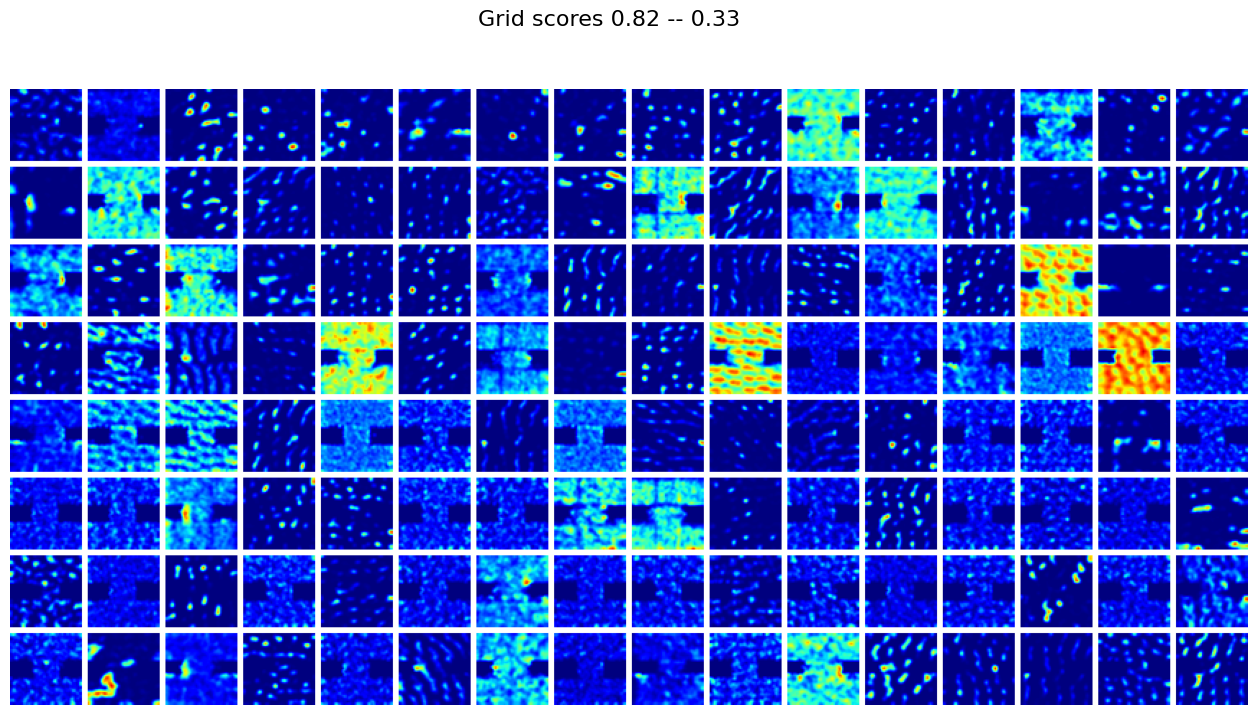

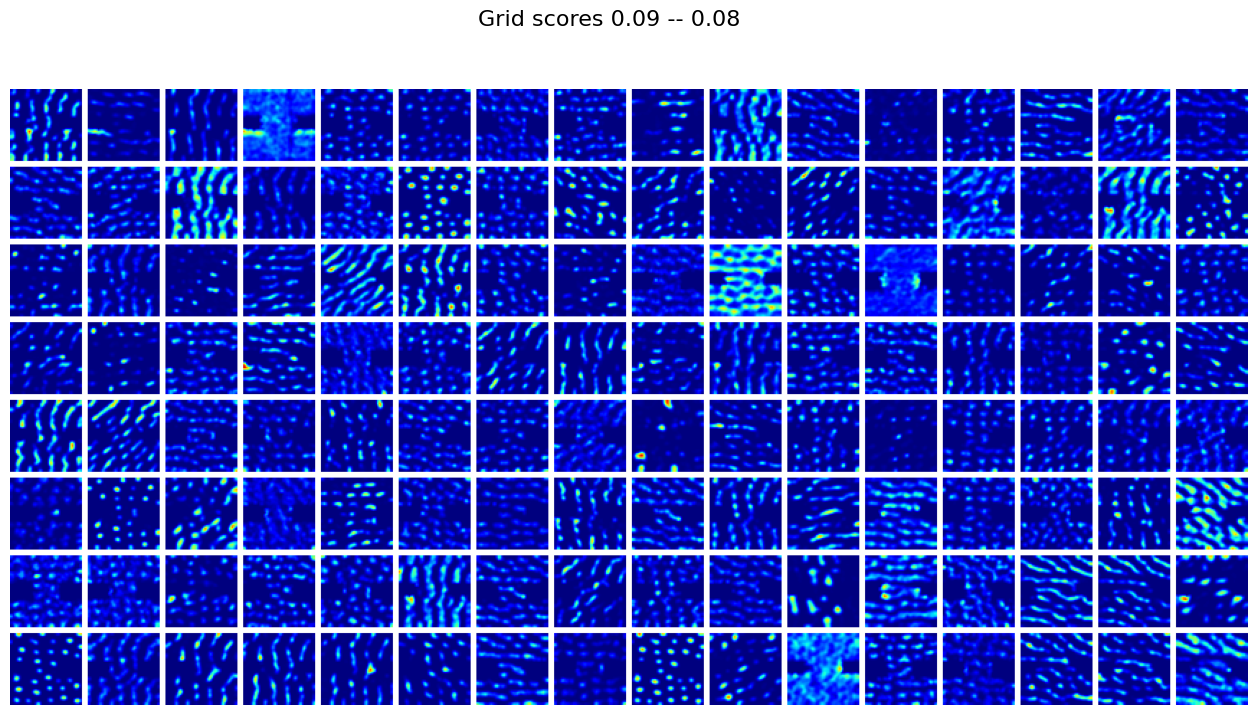

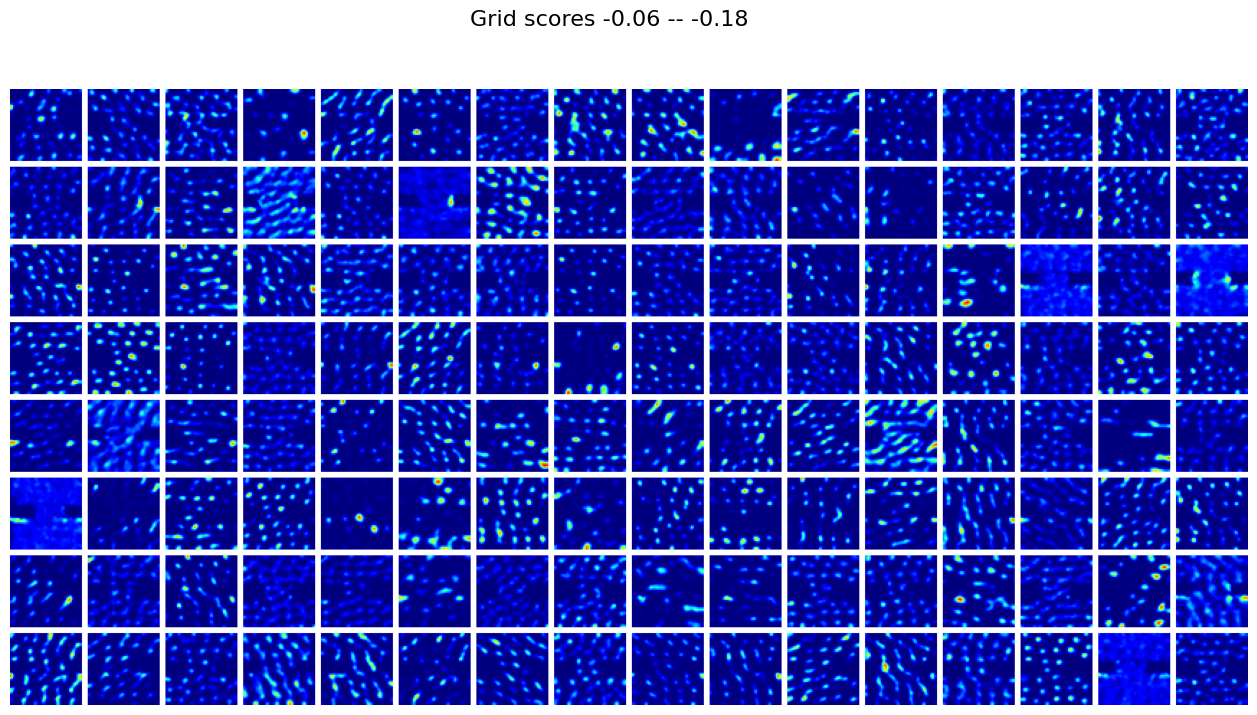

In [18]:
idxs = np.flip(np.argsort(score_60))
Ng = options.Ng

# Plot high grid scores
n_plot = 128
plt.figure(figsize=(16,4*n_plot//8**2))
rm_fig = plot_ratemaps(activations[idxs], n_plot, smooth=True)
plt.imshow(rm_fig)
plt.suptitle('Grid scores '+str(np.round(score_60[idxs[0]], 2))
             +' -- '+ str(np.round(score_60[idxs[n_plot]], 2)),
            fontsize=16)
plt.axis('off');

# Plot medium grid scores
plt.figure(figsize=(16,4*n_plot//8**2))
rm_fig = plot_ratemaps(activations[idxs[Ng//4:]], n_plot, smooth=True)
plt.imshow(rm_fig)
plt.suptitle('Grid scores '+str(np.round(score_60[idxs[Ng//2]], 2))
             +' -- ' + str(np.round(score_60[idxs[Ng//2+n_plot]], 2)),
            fontsize=16)
plt.axis('off');

# Plot low grid scores
plt.figure(figsize=(16,4*n_plot//8**2))
rm_fig = plot_ratemaps(activations[np.flip(idxs)], n_plot, smooth=True)
plt.imshow(rm_fig)
plt.suptitle('Grid scores '+str(np.round(score_60[idxs[-n_plot]], 2))
             +' -- ' + str(np.round(score_60[idxs[-1]], 2)),
            fontsize=16)
plt.axis('off');